In [6]:
# import pyspedas
# from pyspedas.cotrans.tvector_rotate import tvector_rotate
# from pyspedas.cotrans.cotrans_lib import get_time_parts
# from pyspedas import tinterpol
# import scienceplots
import numpy as np
import pandas as pd
import scipy as sp 
from scipy.signal import find_peaks
from scipy.signal import cwt, spectrogram
# import pytplot
# from pytplot import get_data, store_data, get_coords, set_coords, tplot, split_vec, tsmooth, options
# import pytplot
import os
from datetime import datetime
from datetime import timedelta
from scipy import constants as C
import h5py

from scipy.optimize import curve_fit
from scipy.stats import kappa3
from scipy import integrate
from matplotlib import pyplot as plt
from matplotlib import style
import matplotlib.colors as colors
import warnings
import cdflib
warnings.filterwarnings('ignore')
# style.use("science")
# plt.rcParams.update({
#     "font.family": "serif",
#     "font.serif": ["Times"]})

In [201]:
def get_data_files_in_range(time_range, data_dir):
    """
    获取指定时间范围内的数据文件名列表
    
    params:
    time_range: list, 包含开始和结束时间的列表，格式如 ["2015-11-04/00:00:00", "2015-11-07/00:00:00"]
    file_pattern: str, 文件名模式，包含日期占位符
    
    return:
    list: 符合时间范围的文件名列表
    """
    # 解析开始和结束时间
    start_time = datetime.strptime(time_range[0], "%Y-%m-%d/%H:%M:%S")
    end_time = datetime.strptime(time_range[1], "%Y-%m-%d/%H:%M:%S")
    
    # 列出所有文件名称
    files = os.listdir(data_dir)
    # 生成日期列表
    current_date = start_time
    data_files = []
    
    while current_date <= end_time:
        # 生成当前日期的文件名
        date_str = current_date.strftime("%Y%m%d")
        filename = [file for file in files if date_str in file]
        # filename = file_pattern.format(date_str)
        file_dir = data_dir + "\\" + filename[0]
        data_files.append(file_dir)
        
        # 前进到下一天
        current_date += timedelta(days=1)
    
    return data_files

def get_fedu_mean_data(data_dir, time_range):
    # time_range = ["2015-11-05/12:00:00", "2015-11-07/12:00:00"]
    # data_dir = r"E:\data\data\rbsp\rbspb\l3\ect\MAGEIS\l3\2015\\"
    files = get_data_files_in_range(time_range, data_dir)
    datetimes = np.array([])
    Ls = np.array([])
    fedu_90s = np.array([])
    for file in files:
        cdf = cdflib.CDF(file)
        t = cdf.varget("Epoch")
        datetimes_temp = cdflib.epochs.CDFepoch.to_datetime(t)
        datetimes = np.concatenate((datetimes, datetimes_temp))
        
        L = cdf.varget("L")
        Ls = np.hstack((Ls, L))      

        fedu_90 = cdf.varget("FEDU")[:, 5, :]
        if fedu_90s.size == 0:
            fedu_90s = fedu_90
        else:
            fedu_90s = np.concatenate((fedu_90s, fedu_90), axis=0)

    time_range_idx = np.where((datetimes >= datetime.strptime(time_range[0], "%Y-%m-%d/%H:%M:%S")) & (datetimes <= datetime.strptime(time_range[1], "%Y-%m-%d/%H:%M:%S")))[0]
    datetimes = datetimes[time_range_idx]
    Ls = Ls[time_range_idx]
    fedu_90s = fedu_90s[time_range_idx, :]

    fedu_energy = cdf.varget("FEDU_Energy")

    fedu_dataframe = pd.DataFrame(fedu_90s, columns=fedu_energy)
    fedu_dataframe[fedu_dataframe < 0] = np.nan
    fedu_dataframe["L"] = Ls
    fedu_dataframe["datetime"] = datetimes

    fedu_mean_df = pd.DataFrame()
    for l in np.arange(3, 6.55, 0.01):
        lower_bound = l - 0.005
        upper_bound = l + 0.005
        fedu_mean = fedu_dataframe.loc[fedu_dataframe["L"].between(lower_bound,upper_bound), :].mean(axis=0).tolist()[:-2]
        fedu_mean_df["{:.2f}".format(l)] = fedu_mean
    fedu_mean_df["Kec"] = fedu_energy
    fedu_mean_df = fedu_mean_df.dropna(axis=1, how='all').dropna(axis=0, how='any')
    fedu_mean_df[fedu_mean_df < 0] = np.nan
    return fedu_mean_df

def get_L(data_dir, time_range):
    # time_range = ["2015-11-05/12:00:00", "2015-11-07/12:00:00"]
    # data_dir = r"E:\data\data\rbsp\rbspb\l3\ect\MAGEIS\l3\2015\\"
    files = get_data_files_in_range(time_range, data_dir)
    datetimes = np.array([])
    Ls = np.array([])
    for file in files:
        cdf = cdflib.CDF(file)
        t = cdf.varget("Epoch")
        datetimes_temp = cdflib.epochs.CDFepoch.to_datetime(t)
        datetimes = np.concatenate((datetimes, datetimes_temp))
        
        L = cdf.varget("L")
        Ls = np.hstack((Ls, L))

    time_range_idx = np.where((datetimes >= datetime.strptime(time_range[0], "%Y-%m-%d/%H:%M:%S")) & (datetimes <= datetime.strptime(time_range[1], "%Y-%m-%d/%H:%M:%S")))[0]
    datetimes = datetimes[time_range_idx]
    Ls = Ls[time_range_idx]

    return datetimes, Ls


In [94]:
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# def generate_monthly_dates(start_date_str, num_months):
#     # 将字符串转换为datetime对象
#     start_date = datetime.strptime(start_date_str, "%Y-%m-%d/%H:%M:%S")
    
#     # 生成指定数量的月份日期
#     for i in range(num_months):
#         current_date = start_date + relativedelta(months=i)
#         yield current_date.strftime("%Y-%m-%d/%H:%M:%S")
# start = "2013-01-01/00:00:00"
# generate_monthly_dates(start, 78)
# for date in generate_monthly_dates(start, 78):
#     print(date)
mageis_fedu_mean_df = get_fedu_mean_data(r"Q:\data\data\rbsp\rbspb\l3\ect\MAGEIS\l3\2015\\", ["2015-10-01/12:00:00", "2015-11-05/12:00:00"])
mageis_fedu_mean_df['Kec'] = mageis_fedu_mean_df['Kec'] / 1000
rept_fedu_mean_df = get_fedu_mean_data(r"Q:\data\data\rbsp\rbspb\l3\ect\REPT\l3\2015\\", ["2015-09-01/12:00:00", "2015-11-05/12:00:00"])

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def generate_monthly_dates(start_date_str, num_months):
    # 将字符串转换为datetime对象
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d/%H:%M:%S")
    
    # 生成指定数量的月份日期
    for i in range(num_months):
        current_date = start_date + relativedelta(months=i)
        yield current_date.strftime("%Y-%m-%d/%H:%M:%S")
start = "2013-01-01/00:00:00"
for i in generate_monthly_dates(start, 78) :
    print(i)

In [96]:
for column in rept_fedu_mean_df.columns:
    null_rows = rept_fedu_mean_df[rept_fedu_mean_df[column].isna()].index
    if len(null_rows) > 0:
        print(f"列 '{column}' 在以下行包含空值: {list(null_rows)}")


In [218]:
mageis_fedu_mean_df.to_csv("./mageis_fedu_mean.csv", index=False)
rept_fedu_mean_df.to_csv("./rept_fedu_mean.csv", index=False)

In [217]:
mageis_fedu_mean_df = mageis_fedu_mean_df * 1000
mageis_fedu_mean_df['Kec'] = mageis_fedu_mean_df['Kec'] / 1000
mageis_fedu_mean_df

,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,...,6.46,6.47,6.48,6.49,6.50,6.51,6.52,6.53,6.54,Kec
0,3.472488e+08,3.413884e+08,3.445172e+08,3.381350e+08,3.481321e+08,3.366821e+08,3.332762e+08,3.423915e+08,3.318908e+08,3.317265e+08,...,1.150320e+08,1.403196e+08,1.432160e+08,1.435259e+08,1.406095e+08,1.352835e+08,1.396284e+08,1.392484e+08,1.410030e+08,0.032
1,2.830286e+08,2.709036e+08,2.742576e+08,2.677431e+08,2.765100e+08,2.646550e+08,2.598022e+08,2.640684e+08,2.608830e+08,2.576730e+08,...,6.514878e+07,1.010887e+08,1.043529e+08,1.059461e+08,1.078671e+08,1.097117e+08,9.141234e+07,8.876968e+07,8.155850e+07,0.054
2,2.077972e+08,1.989759e+08,1.963073e+08,1.932950e+08,1.978786e+08,1.851999e+08,1.846988e+08,1.844470e+08,1.793159e+08,1.778293e+08,...,3.647325e+07,5.949781e+07,6.330291e+07,6.438001e+07,6.720622e+07,6.768944e+07,5.232329e+07,5.504262e+07,5.684781e+07,0.075
3,1.062108e+08,9.999508e+07,9.814342e+07,9.573782e+07,9.733897e+07,9.129571e+07,9.023948e+07,8.924739e+07,8.620095e+07,8.486559e+07,...,1.771429e+07,3.110069e+07,3.217406e+07,3.202207e+07,3.163248e+07,3.041760e+07,2.552761e+07,2.688356e+07,2.967647e+07,0.102
4,5.097910e+07,4.757351e+07,4.644740e+07,4.524293e+07,4.529077e+07,4.321065e+07,4.182423e+07,4.169709e+07,4.018321e+07,3.908954e+07,...,9.643460e+06,1.644695e+07,1.697855e+07,1.706726e+07,1.673406e+07,1.615087e+07,1.296919e+07,1.339692e+07,1.687512e+07,0.132
5,2.103979e+07,1.988437e+07,1.908924e+07,1.913222e+07,1.846302e+07,1.791530e+07,1.749313e+07,1.722179e+07,1.650580e+07,1.629783e+07,...,5.826009e+06,9.246238e+06,9.531232e+06,9.576729e+06,9.553098e+06,9.550516e+06,7.475211e+06,8.024930e+06,8.490212e+06,0.168
6,9.185331e+06,8.873138e+06,8.470173e+06,8.657568e+06,8.163110e+06,7.993119e+06,7.901171e+06,7.893098e+06,7.419871e+06,7.514456e+06,...,3.610360e+06,5.278072e+06,5.571617e+06,5.720851e+06,5.833598e+06,6.038872e+06,4.472507e+06,4.646900e+06,4.610688e+06,0.208
7,5.602533e+06,5.496413e+06,5.223937e+06,5.412155e+06,5.049282e+06,4.976110e+06,4.984601e+06,5.079707e+06,4.675036e+06,4.862470e+06,...,2.921242e+06,4.116676e+06,4.197308e+06,4.396521e+06,4.486723e+06,4.569982e+06,3.430968e+06,3.423906e+06,3.563659e+06,0.246
8,1.550287e+06,1.573932e+06,1.456254e+06,1.572084e+06,1.460338e+06,1.521917e+06,1.480354e+06,1.637441e+06,1.399047e+06,1.574312e+06,...,1.411105e+06,1.773798e+06,1.761977e+06,1.744479e+06,1.751007e+06,1.751132e+06,1.441852e+06,1.461849e+06,1.624189e+06,0.354
9,4.507766e+05,4.741399e+05,4.344060e+05,4.986644e+05,4.609257e+05,4.907736e+05,4.959949e+05,5.495704e+05,4.788990e+05,5.541545e+05,...,7.821205e+05,9.144229e+05,8.333759e+05,8.550688e+05,8.226805e+05,8.326552e+05,7.476644e+05,7.611544e+05,8.918513e+05,0.470


Rept 能量范围: 1.8 MeV 到 20.0 MeV
Mageis 能量范围: 0.032 MeV 到 3.878 MeV
能量重叠起始点 (Rept 最小能量): 1.8 MeV
能量重叠结束点 (Mageis 最大能量): 3.878 MeV
平滑过渡起始能量: 1.6 MeV
平滑过渡结束能量: 2.0 MeV


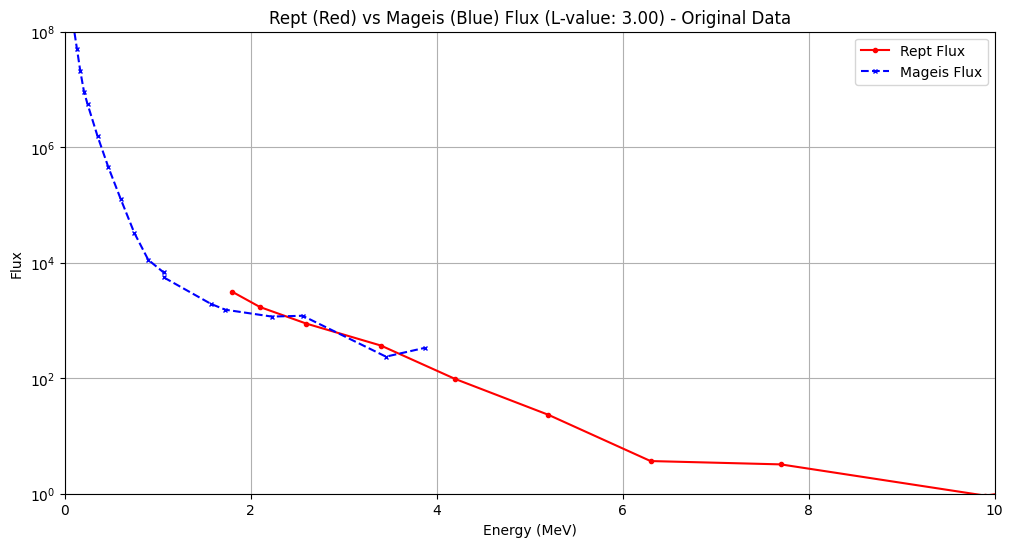

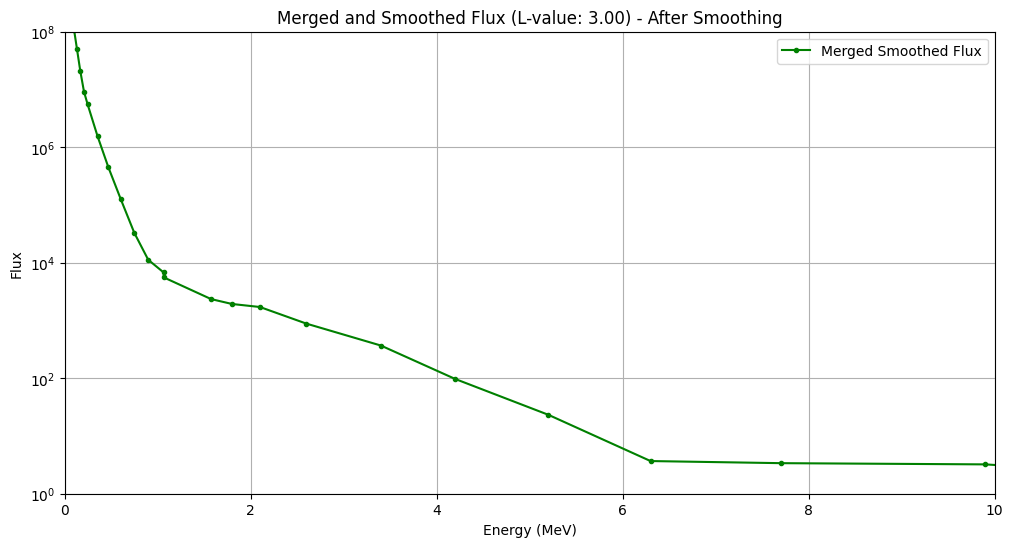

合并并平滑处理后的文件已保存为: ./merged_smoothed_fedu_mean.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载 Rept 和 Mageis 数据 (保持不变)
rept_file = './rept_fedu_mean.csv'
mageis_file = './mageis_fedu_mean.csv'

rept_df = pd.read_csv(rept_file)
mageis_df = pd.read_csv(mageis_file)

rept_energy_col = rept_df.columns[-1]
mageis_energy_col = mageis_df.columns[-1]

rept_df[rept_energy_col] = pd.to_numeric(rept_df[rept_energy_col], errors='coerce')
mageis_df[mageis_energy_col] = pd.to_numeric(mageis_df[mageis_energy_col], errors='coerce')

overlap_start_energy = rept_df[rept_energy_col].min()
overlap_end_energy = mageis_df[mageis_energy_col].max()

# 平滑过渡范围 (保持与上次相同，你可以根据需要调整)
transition_start_energy = 1.6  # MeV -  Start of smooth transition region
transition_end_energy = 2.0    # MeV - End of smooth transition region

print(f"Rept 能量范围: {overlap_start_energy} MeV 到 {rept_df[rept_energy_col].max()} MeV")
print(f"Mageis 能量范围: {mageis_df[mageis_energy_col].min()} MeV 到 {overlap_end_energy} MeV")
print(f"能量重叠起始点 (Rept 最小能量): {overlap_start_energy} MeV")
print(f"能量重叠结束点 (Mageis 最大能量): {overlap_end_energy} MeV")
print(f"平滑过渡起始能量: {transition_start_energy} MeV")
print(f"平滑过渡结束能量: {transition_end_energy} MeV")


merged_columns = list(rept_df.columns[:-1]) + [rept_energy_col]
merged_df = pd.DataFrame(columns=merged_columns)


# 1. 绘制原始数据 (Rept & Mageis) - (保持不变)
l_value_column_for_plot = merged_columns[0]

plt.figure(figsize=(12, 6))
plt.plot(rept_df[rept_energy_col], rept_df[l_value_column_for_plot], label='Rept Flux', marker='o', linestyle='-', markersize=3, color='red')
plt.plot(mageis_df[mageis_energy_col], mageis_df[l_value_column_for_plot], label='Mageis Flux', marker='x', linestyle='--', markersize=3, color='blue')

plt.xlabel('Energy (MeV)')
plt.ylabel('Flux')
plt.title(f'Rept (Red) vs Mageis (Blue) Flux (L-value: {l_value_column_for_plot}) - Original Data')
plt.xlim(0, 10)
plt.ylim(1e0, 1e8)
plt.yscale('log')
plt.legend()

plt.grid(True)
plt.show()


# 2. 添加 Mageis 数据中能量小于 transition_start_energy 部分 (保持不变)
mageis_part = mageis_df[mageis_df[mageis_energy_col] < transition_start_energy].copy()
merged_df = pd.concat([merged_df, mageis_part], ignore_index=True)


# 3. 处理能量重叠部分，进行中值平滑过渡  <-----  关键修改在这里！
overlap_energies = rept_df[(rept_df[rept_energy_col] >= transition_start_energy) & (rept_df[rept_energy_col] <= transition_end_energy)].copy()

if not overlap_energies.empty:
    def smooth_flux_median(row): # 修改平滑函数为中值平滑
        energy = row[rept_energy_col]


        mageis_row = mageis_df.iloc[(mageis_df[mageis_energy_col] - energy).abs().argsort()[:1]]
        smoothed_row = row.copy()
        for l_col in merged_columns[:-1]:
            rept_flux = row[l_col]
            mageis_flux = mageis_row[l_col].iloc[0]
            smoothed_flux = (rept_flux + mageis_flux) / 2.0 #  <--- 仍然使用平均值，先尝试线性权重
            smoothed_flux = pd.Series([rept_flux, mageis_flux]).median() # 使用中值平滑  <---  关键修改：使用中值
            smoothed_row[l_col] = smoothed_flux
        return smoothed_row

    smoothed_part = overlap_energies.apply(smooth_flux_median, axis=1) # 使用新的平滑函数 (中值)
    merged_df = pd.concat([merged_df, smoothed_part], ignore_index=True)


# 4. 添加 Rept 数据中能量大于 transition_end_energy 部分 (保持不变)
rept_part = rept_df[rept_df[rept_energy_col] >= transition_end_energy].copy()
merged_df = pd.concat([merged_df, rept_part], ignore_index=True)


# Sort merged_df by energy (保持不变)
merged_df = merged_df.sort_values(by=rept_energy_col, ignore_index=True)

window_size = 5  #  <----  滚动窗口大小，可以调整 (例如 3, 5, 7)
merged_smoothed_df = merged_df.copy()

for l_col in merged_columns[:-1]: # 对每个 L 值列进行平滑
    merged_smoothed_df[l_col] = merged_df[l_col].rolling(window=window_size, center=True, min_periods=1).median()

plt.figure(figsize=(12, 6))
plt.plot(merged_smoothed_df[rept_energy_col], merged_smoothed_df[merged_columns[0]], label='Merged Smoothed Flux', marker='o', linestyle='-', markersize=3, color='green') # 绿色表示合并后的数据

plt.xlabel('Energy (MeV)')
plt.ylabel('Flux')
plt.title(f'Merged and Smoothed Flux (L-value: {merged_columns[0]}) - After Smoothing') # 标题更明确
plt.xlim(0,10)
plt.ylim(1e0, 1e8)
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# 保存合并后的文件 (保持不变)
output_file = './merged_smoothed_fedu_mean.csv'
merged_smoothed_df.to_csv(output_file, index=False)

print(f"合并并平滑处理后的文件已保存为: {output_file}")




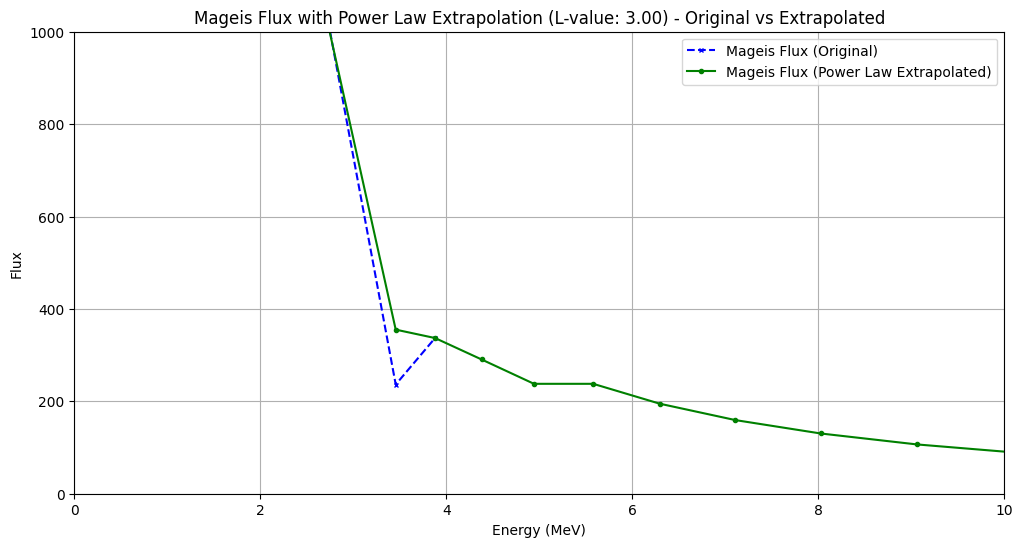

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit  # 导入 curve_fit 函数

# 加载 Mageis 数据 (保持不变)
mageis_file = 'mageis_fedu_mean.csv'
mageis_df = pd.read_csv(mageis_file)

mageis_energy_col = mageis_df.columns[-1]

if mageis_energy_col == 'Kec':
    mageis_df = mageis_df.rename(columns={'Kec': 'Kev'})
    mageis_energy_col = 'Kev'

mageis_df[mageis_energy_col] = pd.to_numeric(mageis_df[mageis_energy_col], errors='coerce')


overlap_end_energy = mageis_df[mageis_energy_col].max() # Mageis 最大能量，用于定义外推起始点
merged_columns = list(mageis_df.columns[:-1]) + [mageis_energy_col]
merged_df = pd.DataFrame(columns=merged_columns)

#  定义幂律函数
def power_law_func(x, a, b): # 定义幂律函数
    return a * np.power(x, b)

# 2. 能量范围扩展 - 使用 Mageis 数据进行幂律外推  <----- 关键修改：幂律外推 ----------------------
num_extrapolation_points = 20 # 外推能量点数量
extrapolated_data_dict = {} 
for l_col in merged_columns[:-1]:
# extrapolation_l_value_col = merged_columns[0] # 选择用于外推的 L 值列

    # 2.2. 准备 Mageis 数据用于拟合 (使用 Mageis 数据最后几个点)
    mageis_extrapolation_data = mageis_df.tail(5).dropna(subset=[l_col, mageis_energy_col])

    # 移除通量 <= 0 的数据点，避免 log10 错误 (重要!)
    mageis_extrapolation_data = mageis_extrapolation_data[mageis_extrapolation_data[l_col] > 0]


    # 2.3. 幂律拟合  <----- 关键修改：使用 curve_fit 进行非线性拟合
    if not mageis_extrapolation_data.empty: # 确保有数据用于拟合
        X_train = mageis_extrapolation_data[mageis_energy_col].values # 能量作为特征
        y_train = mageis_extrapolation_data[l_col].values # 通量作为目标

        popt, pcov = curve_fit(power_law_func, X_train, y_train, p0=[1, -2]) # 使用 curve_fit 进行幂律拟合, p0 提供初始参数估计
        a_opt, b_opt = popt # 提取最优拟合参数


        # 2.4. 生成外推能量点 (超出 Mageis 能量范围)
        last_mageis_energy = mageis_df[mageis_energy_col].max()
        extended_energies = np.logspace(np.log10(last_mageis_energy), np.log10(overlap_end_energy * 10), num=num_extrapolation_points)[1:] #  logspace 生成对数均匀分布的点

        # 2.5.  预测外推能量点对应的通量值 (使用幂律函数预测)
        predicted_fluxes = power_law_func(extended_energies, *popt) # 使用最优参数和幂律函数预测
        predicted_fluxes = np.maximum(0, predicted_fluxes) # 确保通量值非负


        extrapolated_data_dict[l_col] = predicted_fluxes #  存储每个 L 值列的外推通量

    else:
        extrapolated_data_dict[l_col] = np.full(num_extrapolation_points, np.nan) # 如果 mageis_extrapolation_data 为空，则只使用原始 Mageis 数据

extended_energies_df = pd.DataFrame({mageis_energy_col: extended_energies}) #  创建能量列
extrapolated_df = pd.DataFrame(extrapolated_data_dict) #  基于字典创建通量列
extrapolated_data = pd.concat([extrapolated_df, extended_energies_df], axis=1)

# Sort merged_df by energy (保持不变)
merged_df = pd.concat([mageis_df, extrapolated_data], ignore_index=True)
merged_df = merged_df.sort_values(by=mageis_energy_col, ignore_index=True)

window_size = 7  #  <----  滚动窗口大小，可以调整 (例如 3, 5, 7)
merged_smoothed_df = merged_df.copy()

for l_col in merged_columns[:-1]: # 对每个 L 值列进行平滑
    merged_smoothed_df[l_col] = merged_df[l_col].rolling(window=window_size, center=True, min_periods=1).median()

merged_df = merged_smoothed_df

# 3. 绘制合并后并**扩展能量范围后**的 Mageis 数据  <----- 修改了绘图对象和标题 -------------------------
plt.figure(figsize=(12, 6))
plt.plot(mageis_df[mageis_energy_col], mageis_df[merged_columns[0]], label='Mageis Flux (Original)', marker='x', linestyle='--', markersize=3, color='blue') #  蓝色表示原始 Mageis 数据
plt.plot(merged_df[mageis_energy_col], merged_df[merged_columns[0]], label='Mageis Flux (Power Law Extrapolated)', marker='o', linestyle='-', markersize=3, color='green') # 绿色表示最终平滑数据 (包含外推)

plt.xlabel('Energy (MeV)')
plt.ylabel('Flux')
plt.title(f'Mageis Flux with Power Law Extrapolation (L-value: {merged_columns[0]}) - Original vs Extrapolated') # 更明确的标题
plt.xlim(0, 10)
# plt.yscale('log')
plt.ylim(0, 1000)
plt.legend()
plt.grid(True)
plt.show()
# -----------------------------------------------------------------------
output_file = './mageis_extended_fedu_mean.csv' # 文件名修改
merged_df.to_csv(output_file, index=False)

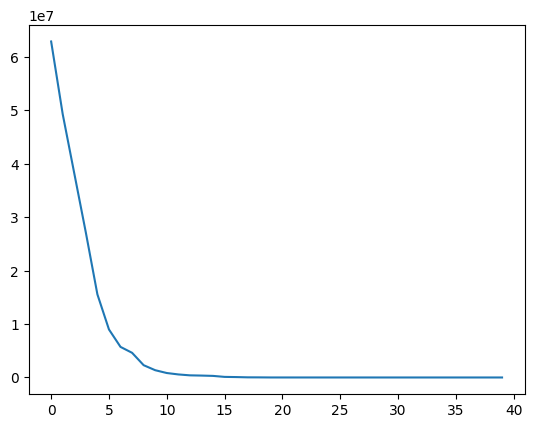

In [186]:
plt.plot(merged_df.loc[:, "6.00"].values[:-1])

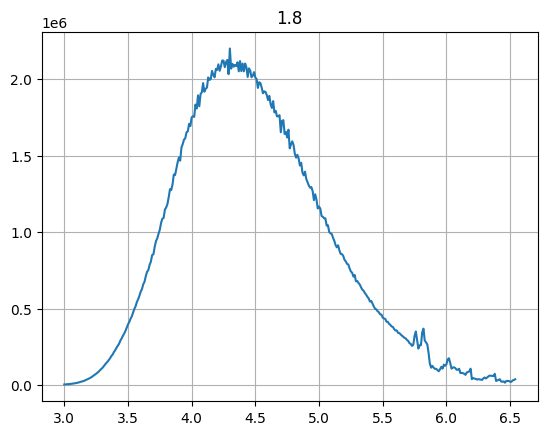

In [128]:
from scipy.ndimage import gaussian_filter1d
i = 0
y = rept_fedu_mean_df.loc[i, :][:-1]
x = rept_fedu_mean_df.columns[:-1].astype(float)
y = gaussian_filter1d(y, sigma=0.1)
Kecs = rept_fedu_mean_df.Kec
plt.plot(x, y)
plt.title(Kecs[i])
# plt.xlim(6.2, 6.5)
# plt.ylim(0,50000)
plt.grid()

In [130]:
y[350]

21310.061576261436

In [8]:
# rept flux data process and to dataframe
rept_file = r"E:\home\DATA\rbspb\l3\rept\2015\rbspb_rel03_ect-rept-sci-l3_20151106_v5.0.0.cdf"
pyspedas.cdf_to_tplot(rept_file)
def t2datetime(t):
    time_parts = get_time_parts(t)
    years, doys, hrs, mins, secs = time_parts[0], time_parts[1], time_parts[2], time_parts[3], time_parts[4]
    datetimes = [datetime(year, 1, 1) + timedelta(days=int(doy-1), hours=int(hours), minutes=int(minutes), seconds=seconds) for year, doy, hours, minutes, seconds in zip(years, doys, hrs, mins, secs)]
    return datetimes

datetimes = np.array(t2datetime(get_data("FEDU").times))
time_range = np.where(np.array(datetimes) < datetime(2015, 11, 6, 18, 0, 0))
time = datetimes[time_range]
fedu_90 = get_data("FEDU").y[time_range, 5, :]
L = get_data("L").y[time_range]

fedu_dataframe = pd.DataFrame(np.squeeze(fedu_90), columns=get_data("FEDU").v2)
fedu_dataframe["L"] = L

fedu_mean_df = pd.DataFrame()
for l in np.arange(3, 6.55, 0.05):
    lower_bound = l - 0.025
    upper_bound = l + 0.025
    fedu_mean = fedu_dataframe.loc[fedu_dataframe["L"].between(lower_bound,upper_bound), :].mean(axis=0).tolist()[:-1]
    fedu_mean_df["{:.2f}".format(l)] = fedu_mean
fedu_mean_df["Kec"] = get_data("FEDU").v2
fedu_mean_df = fedu_mean_df.dropna(axis=1, how='all').dropna(axis=0, how='any')
fedu_mean_df.to_csv("./rept_observed_flux.csv", index=False)

02-Jan-25 16:04:08: No VAR_TYPE or PARAMETER_TYPE attributes defined for variable FEDU_Unbinned_Sector_Angle, skipping
02-Jan-25 16:04:08: No VAR_TYPE or PARAMETER_TYPE attributes defined for variable FPDU_Unbinned_Sector_Angle, skipping
02-Jan-25 16:04:12: Length of v (1) and x (7888) do not match.  Cannot create tplot variable FPDU.
02-Jan-25 16:04:12: Length of v (1) and x (7888) do not match.  Cannot create tplot variable FPDU_0to180.
02-Jan-25 16:04:12: FPDU_0to180 is currently not in pytplot.
02-Jan-25 16:04:12: FPDU_0to180 is currently not in pytplot.
02-Jan-25 16:04:12: FPDU_0to180 is currently not in pytplot.
02-Jan-25 16:04:12: FPDU_0to180 is currently not in pytplot.
02-Jan-25 16:04:12: Length of v (1) and x (7888) do not match.  Cannot create tplot variable FPDU_180to360.
02-Jan-25 16:04:12: FPDU_180to360 is currently not in pytplot.
02-Jan-25 16:04:12: FPDU_180to360 is currently not in pytplot.
02-Jan-25 16:04:12: FPDU_180to360 is currently not in pytplot.
02-Jan-25 16:04:

In [9]:
time_range = np.where(np.logical_and(np.array(datetimes) < datetime(2015, 11, 6, 18, 30, 0),np.array(datetimes) > datetime(2015, 11, 6, 18, 18, 0)))
time = datetimes[time_range]
fedu_90 = get_data("FEDU").y[time_range, 5, :]
L = get_data("L").y[time_range]
mlt = get_data("MLT").y[time_range]
mlt

urad = np.arcsin(1)	# equatorial plane: theta = 90 deg

BFr = -(1/np.arctan(urad))
BFr

-0.9961302115847185

In [ ]:
mageis_observed_flux = pd.read_csv("./mageis_fedu_mean.csv")
rept_observed_flux = pd.read_csv("./rept_fedu_mean.csv")
# mageis_observed_flux = mageis_observed_flux.loc[mageis_observed_flux["Kec"]<1.6, :]
observed_flux = pd.merge(mageis_observed_flux, rept_observed_flux, how='outer')
observed_flux.to_csv("./observed_flux.csv", index=False)

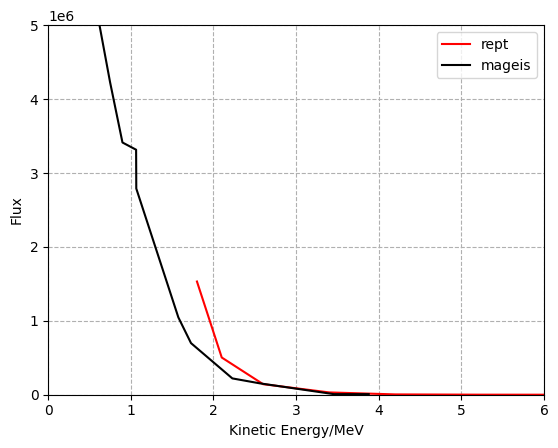

In [11]:
rept_kecs = rept_observed_flux["Kec"]
mageis_kecs = mageis_observed_flux["Kec"]
L = 5
rept_flux = rept_observed_flux["{:.2f}".format(L)]
# rept_flux = rept_flux / integrate.trapz(rept_flux, rept_kecs) 
mageis_flux = mageis_observed_flux["{:.2f}".format(L)]
# mageis_flux = mageis_flux / integrate.trapz(mageis_flux, mageis_kecs) 
plt.plot(rept_kecs, rept_flux, c="r", label="rept")
plt.plot(mageis_kecs, mageis_flux, c='k', label='mageis')
plt.ylim(0,5e6)
plt.xlim(0,6)
plt.xlabel("Kinetic Energy/MeV")
plt.ylabel("Flux")
plt.legend()
plt.grid(linestyle='--')

(0.0, 0.25)

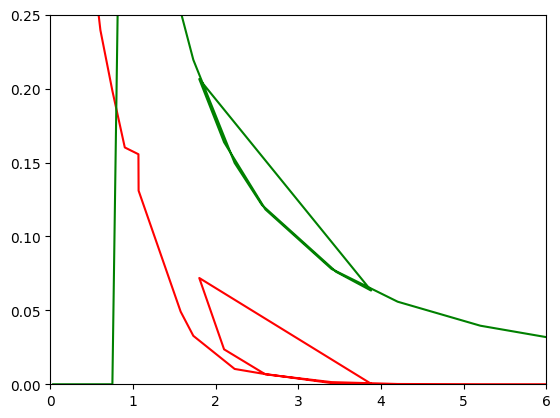

In [12]:
from scipy.optimize import curve_fit
from scipy.stats import kappa3
from scipy import integrate
def func_kappa(x, a, loc, scale):
    return kappa3.pdf(x, a, loc, scale) # a: shape param, loc:location param, scale: scale param

fit_flux = observed_flux
xdata = fit_flux["Kec"]
ydata = fit_flux["5.00"]
ydata = ydata / integrate.trapz(ydata, xdata) 
popt, pcov = curve_fit(func_kappa, xdata, ydata)
yfitted = func_kappa(xdata, *popt)
# yfitted = func_kappa(xdata, *[0.01, 0.032, 1.19])
plt.plot(xdata, ydata, c='r')
plt.plot(xdata, yfitted, c='g')
plt.xlim(0,6)
plt.ylim(0,0.25)

In [13]:
L = 5.42
mod005 = divmod(L, 0.05)
if mod005[1] < 0.025:
    nearest_L = np.round(mod005[0] * 0.05, 2)
else:
    nearest_L = np.round((mod005[0] + 1) * 0.05, 2)
nearest_L

5.4

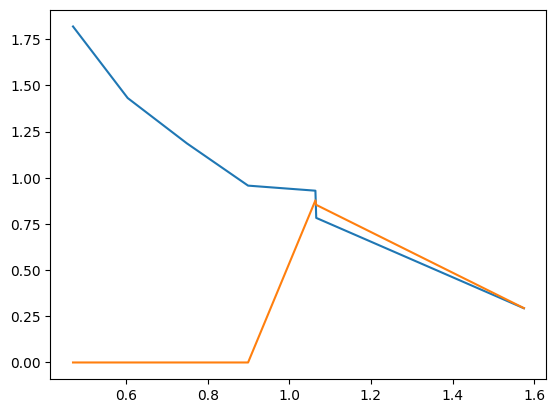

In [14]:
from scipy.optimize import curve_fit
from scipy.stats import kappa3
from scipy import integrate
def func_kappa(x, a, loc, scale):
    return kappa3.pdf(x, a, loc, scale) # a: shape param, loc:location param, scale: scale param

fit_flux = observed_flux.loc[(observed_flux["Kec"]<1.7) & (observed_flux["Kec"]>0.4), :]
xdata = fit_flux["Kec"]
ydata = fit_flux["5.00"]
ydata = ydata / integrate.trapz(ydata, xdata) 
popt, pcov = curve_fit(func_kappa, xdata, ydata)
yfitted = func_kappa(xdata, *popt)
plt.plot(xdata, ydata)
plt.plot(xdata, yfitted)

In [15]:
import random
a = random.random()*3
b = random.random()*3
print(a, b)

1.6730057262609184 1.5614773109704765


(0.0, 10000000.0)

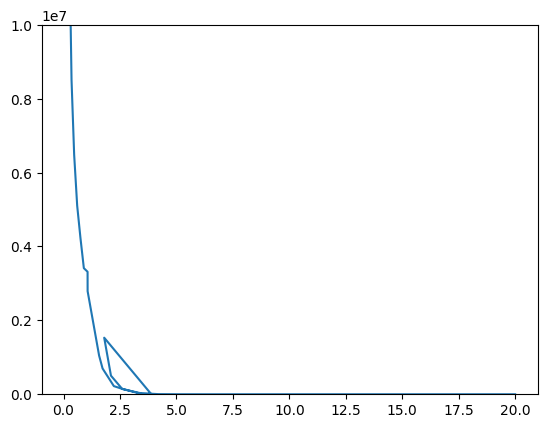

In [16]:
xdata = observed_flux["Kec"]
ydata = observed_flux["5.00"]
plt.plot(xdata, ydata)
plt.ylim(0, 1e7)

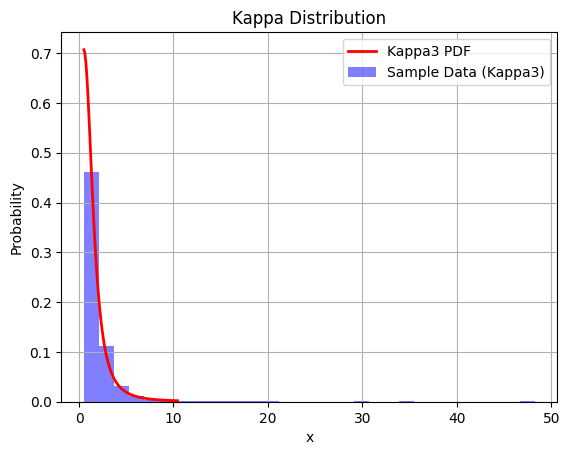

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kappa3, kappa4

# 设置 Kappa 分布的参数
k = 2.0  # 形状参数
s = 0.5  # 尺度参数
c = 0.0  # 位置参数（仅适用于 kappa4）

# 生成一些随机样本
data_kappa3 = kappa3.rvs(k, s, size=1000)
# data_kappa4 = kappa4.rvs(k, s, c, size=1000)

# 绘制 Kappa3 分布的概率密度函数
x = np.linspace(kappa3.ppf(0.01, k, s), kappa3.ppf(0.99, k, s), 100)
plt.plot(x, kappa3.pdf(x, k, s), 'r-', lw=2, label='Kappa3 PDF')

# # 绘制 Kappa4 分布的概率密度函数
# x = np.linspace(kappa4.ppf(0.01, k, s, c), kappa4.ppf(0.99, k, s, c), 100)
# plt.plot(x, kappa4.pdf(x, k, s, c), 'g-', lw=2, label='Kappa4 PDF')

# 绘制随机样本的直方图
plt.hist(data_kappa3, bins=30, density=True, alpha=0.5, color='b', label='Sample Data (Kappa3)')
# plt.hist(data_kappa4, bins=30, density=True, alpha=0.5, color='y', label='Sample Data (Kappa4)')

plt.title('Kappa Distribution')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

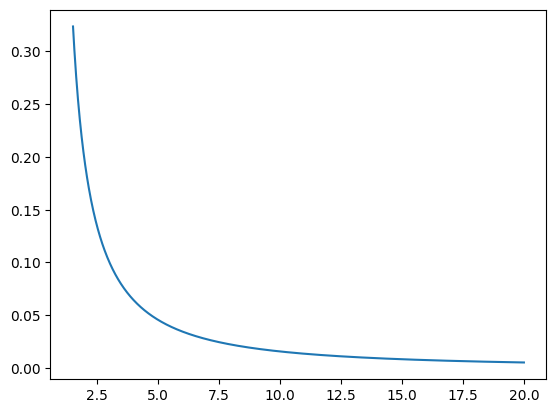

In [18]:
x = np.linspace(1.5, 20, 1000)
y = kappa3.pdf(x, *popt)
plt.plot(x, y)

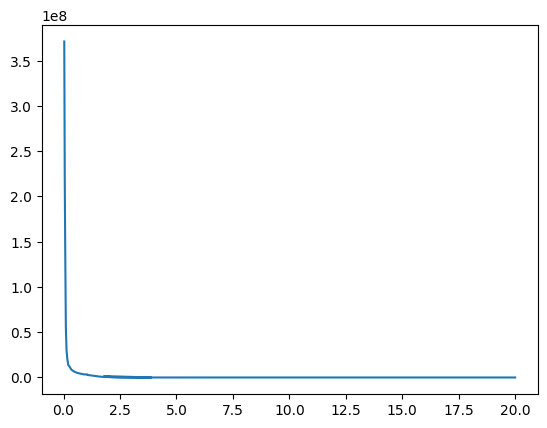

In [19]:
plt.plot(xdata, ydata)

In [20]:
kappa3.pdf(0.3, 3, 0.3, 1)

0.6933612743506348

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 定义指数函数
def exp_func(x, a, b, c):
    return a * b**(c * x)

# 生成模拟数据
x = xdata[14:]
y = ydata[14:]
# 使用 curve_fit 进行拟合
popt, pcov = curve_fit(exp_func, x, y, p0=(1, 1, -1))  # 初始猜测参数 (1, 1, 1)

# 拟合参数
a, b, c = popt
print(f"Fitted Parameters: a={a}, b={b}, c={c}, d={d}")

# 绘制拟合结果
y_fit = exp_func(x, *popt)
plt.scatter(x, y, label='Original Data')
plt.plot(x, y_fit, color='red', label=f'Fitted Curve: $y={a:.2f}*{b:.5f}^{{{c:.2f}x}}$')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exponential Function Fitting')

NameError: name 'd' is not defined

拟合均值: 4.64, 拟合标准差: -0.54, 拟合幅度: 2147400.98


Text(0.5, 1.0, 'Gaussian Fit')

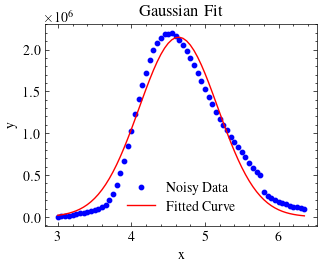

In [82]:
flux = observed_flux.loc[observed_flux["Kec"]==1.800, :].values[0][:-1]
ls = np.arange(3, 6.4, 0.05)

def gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# np.random.seed(42)
mu, sigma = 4.5, 1  # 理想的均值和标准差
x = ls
y = flux

# 使用 curve_fit 进行拟合
popt, pcov = curve_fit(gaussian, x, y, p0=[0, 1, 1])

# 提取拟合参数
mu_fit, sigma_fit, amplitude_fit = popt
print(f"拟合均值: {mu_fit:.2f}, 拟合标准差: {sigma_fit:.2f}, 拟合幅度: {amplitude_fit:.2f}")

# 绘制数据和拟合曲线
plt.scatter(x, y, label="Noisy Data", color="blue", s=10)
plt.plot(x, gaussian(x, *popt), label="Fitted Curve", color="red")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gaussian Fit")

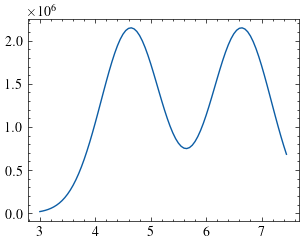

In [83]:
def double_gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + amplitude * np.exp(-((x - mu-2) ** 2) / (2 * sigma ** 2))
x2 = np.arange(3, 7.5, 0.05)
y2 = double_gaussian(x2, *popt)
plt.plot(x2, y2)

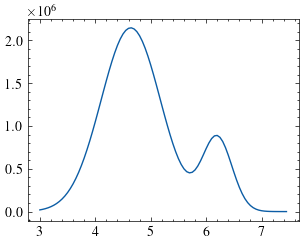

In [80]:
def normal_distribution(x, amplitude, mean, stddev):
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)
def double_normal_distribution(x, amplitude, mean, stddev):
    guass1 = amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)
    guass2 = amplitude * 0.4 * np.exp(-0.5*((x - 6.2)/ stddev*2)**2)

    return guass1 + guass2

x2 = np.arange(3, 7.5, 0.05)
y2 = double_normal_distribution(x2, *[2.14740098e+06, 4.64036399e+00, -5.35173543e-01])
plt.plot(x2, y2)

array([ 4.64036399e+00, -5.35173543e-01,  2.14740098e+06])

In [2]:
np.arange(5.5, 6.5, 0.1)

array([5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4])

In [66]:
mageis_observed_flux = pd.read_csv("./mageis_observed_flux.csv")
rept_observed_flux = pd.read_csv("./rept_observed_flux.csv")
mageis_observed_flux = mageis_observed_flux.loc[mageis_observed_flux["Kec"]<1.6, :]
observed_flux = pd.merge(mageis_observed_flux, rept_observed_flux, how='outer')

def str2list(string):
    original_list = string.replace("[", "").replace("]","").strip().split(" ")
    filtered_list = [element for element in original_list if element.strip() != '']
    list = [float(i) for i in filtered_list]
    return list

def kec_label(wtot):
    kec = (wtot/C.elementary_charge/1e6 - 0.511) * 1000
    if kec > 400 and kec < 600:
        return 500
    elif kec > 700 and kec < 900:
        return 800
    elif kec > 900 and kec < 1100:
        return 1000
    elif kec > 1400 and kec < 1600:
        return 1500
    elif kec > 1600 and kec < 2000:
        return 1800
    elif kec > 2000 and kec < 2500:
        return 2100    
    elif kec > 2500 and kec < 3200:
        return 2600
    elif kec > 3200 and kec < 4000:
        return 3400
    elif kec > 4000 and kec < 5000:
        return 4200
    elif kec > 5000 and kec < 6200:
        return 5200
    else:
        return 0

def kappa3_param(L):
    fit_flux = observed_flux
    xdata = fit_flux["Kec"]
    ydata = fit_flux["{:.2f}".format(L)]
    ydata = ydata / integrate.trapz(ydata, xdata) 
    popt, pcov = curve_fit(func_kappa, xdata, ydata)    
    return popt

def exp_param_dict():
    Ls = np.arange(3, 8.5, 0.05)
    Ls = np.round(Ls, 2)
    exp_dict = {L:[] for L in Ls}
    for L in Ls:
        L_temp = 6.35 if L > 6.35 else L
        fit_flux = observed_flux
        xdata = fit_flux["Kec"]
        ydata = fit_flux["{:.2f}".format(L_temp)]
        ydata = ydata / integrate.trapz(ydata, xdata) 
        popt, pcov = curve_fit(func_exp, xdata[14:], ydata[14:], p0=(1,1,-1))
        exp_dict[L] = popt
    return exp_dict

def func_kappa(x, a, loc, scale):
    return kappa3.pdf(x, a, loc, scale) # a: shape param, loc:location param, scale: scale param
def func_exp(x, a, b, c):
    return a * b ** (c*x)

def normal_distribution(x, amplitude, mean, stddev):
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)
def double_normal_distribution(x, amplitude, mean, stddev):
    guass1 = amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)
    guass2 = amplitude * np.exp(-0.5 * ((x - mean - 2.2)/ stddev*2)**2)
    return guass1

exp_dict =  exp_param_dict() # 指数分布参数表
def get_flux(L, kec):
    """
    根据初始L值和能量确定粒子通量
    L:L SHELL
    kec: kinetic_energy/MeV
    """
    # 根据初始L值和能量确定粒子通量
    x = [float(i) for i in observed_flux.columns[:-1]] # 观测到的L值 
    y =  observed_flux.loc[observed_flux["Kec"]==1.8,:].to_numpy().squeeze()[:-1] # 观测到的通量（1.8MeV）
    # 使用正态分布曲线进行拟合
    popt, pcov = curve_fit(normal_distribution, x, y)  # 通量和L值的关系近似为正态分布
    y_fit = double_normal_distribution(L, *popt) # 在L处的1.8MeV电子的通量（双高斯分布拟合）
    # y_fit_6_30 = double_normal_distribution(6.30, *popt)
    # flux_6_30 = observed_flux.loc[observed_flux["Kec"]==1.8, ["{:.2f}".format(6.30)]].to_numpy()[0][0]
    # kev1800_flux = y_fit * flux_6_30 / y_fit_6_30
    # kappa_params = kappa3_param_dict[nearest_L]
    # density1800 = kappa3.pdf(1.8, *kappa_params)
    # densitykec = kappa3.pdf(kec, *kappa_params)

    exp_params = exp_dict[np.round(5, 2)] # 在L处的指数分布拟合参数
    density1800 = func_exp(1.8, *exp_params)
    densitykec = func_exp(kec, *exp_params)
    ratio = densitykec / density1800
    # fitted_flux = double_normal_distribution(L, popt[0]*ratio, popt[1], popt[2])
    fitted_flux = (densitykec / density1800) * y_fit
    return fitted_flux


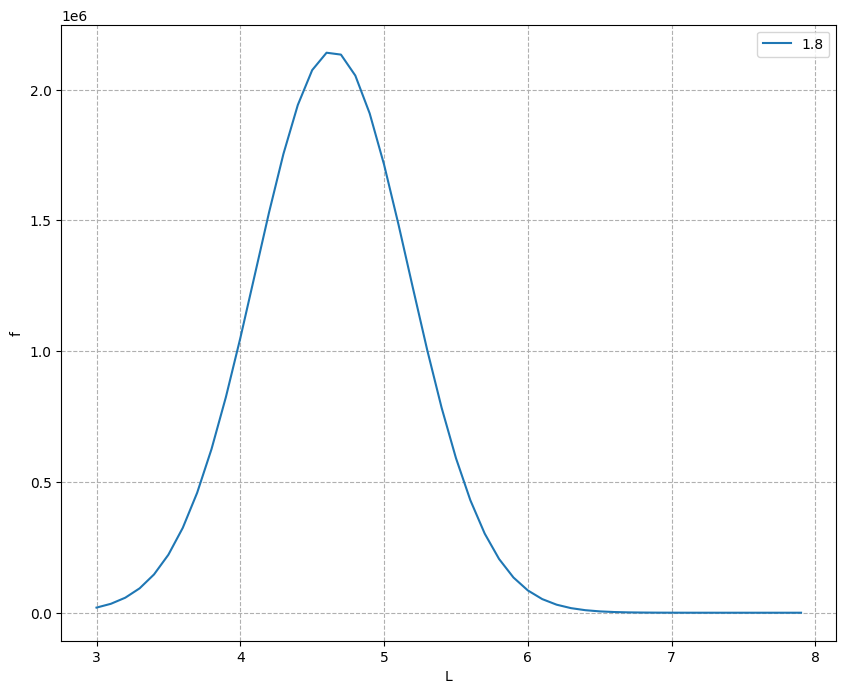

In [84]:
# x = np.arange(0.5, 5.2, 0.1)
x = np.arange(3, 8, 0.1)

plt.figure(figsize=(10, 8),dpi=100)
for j in [1.8]:
    y = [get_flux(i, j) for i in x]
    plt.xlabel("L")
    plt.ylabel("f")
    plt.plot(x, y, label=str(j))


# plt.yscale("log")
plt.legend()
plt.grid(linestyle='--')
# plt.ylim(1e0, 1e7)

In [85]:
print(y[32], y[35])

30740.243260057006 5128.589268245677


In [196]:
import numpy as np
import pandas as pd
import scipy as sp 
import os

from scipy import constants as C
from scipy.optimize import curve_fit
from scipy.stats import kappa3
from scipy import integrate
import glob

def kec_label_batch(wtot_array):
    kec_array = (wtot_array / C.elementary_charge / 1e6 - 0.511) * 1000
    # 定义能道区间和对应的能道标签
    ranges = [
        (300, 600, 500),
        (700, 900, 800),
        (900, 1200, 1000),
        (1200, 1600, 1500),
        (1600, 2000, 1800),
        (2000, 2500, 2100),
        (2500, 3200, 2600),
        (3200, 4000, 3400),
        (4000, 5000, 4200),
        (5000, 6200, 5200),
    ]
    labels = np.zeros_like(kec_array, dtype=int)

    # 根据区间查找标签
    for lower, upper, label in ranges:
        mask = (kec_array > lower) & (kec_array < upper)
        labels[mask] = label
    return labels   

def func_kappa(x, a, loc, scale):
    return kappa3.pdf(x, a, loc, scale) # a: shape param, loc:location param, scale: scale param
def func_exp(x, a, b, c):
    return a * b ** (c*x)

def normal_distribution(x, amplitude, mean, stddev):
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)
def double_normal_distribution(x, amplitude, mean, stddev):
    guass1 = amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)
    guass2 = amplitude * np.exp(-0.5 * ((x - mean - 2)/ stddev*2)**2)
    return guass1 + guass2


def exp_param_dict():
    Ls = np.arange(3, 7.5, 0.05)
    Ls = np.round(Ls, 2)
    exp_dict = {L:[] for L in Ls}
    for L in Ls:
        L_temp = 6.35 if L > 6.35 else L
        fit_flux = observed_flux
        xdata = fit_flux["Kec"]
        ydata = fit_flux["{:.2f}".format(L_temp)]
        ydata = ydata / integrate.trapz(ydata, xdata) 
        popt, pcov = curve_fit(func_exp, xdata[14:], ydata[14:], p0=(1,1,-1))
        exp_dict[L] = popt
    return exp_dict

def get_flux_batch(batch_data):
    L_shell_array = np.sqrt(batch_data[:, 1, :]**2 + batch_data[:, 2, :]**2, + batch_data[:, 3, :]**2)
    wtot_array = batch_data[:,-1,:]
    flux_array = np.zeros_like(wtot_array)
    wtot_init_array = batch_data[:, -1, 0]
    kec_init_array = (wtot_init_array / C.elementary_charge / 1e6 - 0.511) # MeV
    L_init = L_shell_array[:, 0]
    mod005 = divmod(L_init, 0.05)
    mask = (mod005[1] < 0.025)
    L_init_near_array = np.zeros_like(L_init)
    L_init_near_array[mask] = np.round(mod005[0][mask] * 0.05, 2)
    L_init_near_array[~mask] = np.round((mod005[0]+1)[~mask] * 0.05, 2)
    exp_params = [exp_dict[L] for L in L_init_near_array]
    x = [float(i) for i in observed_flux.columns[:-1]] # 观测到的L值 
    y =  observed_flux.loc[observed_flux["Kec"]==1.8,:].to_numpy().squeeze()[:-1] # 观测到的通量（1.8MeV）
    # 使用正态分布曲线进行拟合
    popt, pcov = curve_fit(normal_distribution, x, y)  # 通量和L值的关系近似为正态分布
    y_fit = normal_distribution(L_init_near_array, *popt) # 在L处的1.8MeV电子的通量（双高斯分布拟合）

    density1800 = np.array([func_exp(1.8, *exp) for exp in exp_params])
    densitykec = np.array([func_exp(i[0], *i[1]) for i in zip(kec_init_array, exp_params)])
    fitted_flux = (densitykec / density1800) * y_fit
    print(np.shape(fitted_flux))
    return fitted_flux

mageis_observed_flux = pd.read_csv("./mageis_observed_flux.csv")
rept_observed_flux = pd.read_csv("./rept_observed_flux.csv")
mageis_observed_flux = mageis_observed_flux.loc[mageis_observed_flux["Kec"]<1.6, :]
observed_flux = pd.merge(mageis_observed_flux, rept_observed_flux, how='outer')


batch_files_folder = r"./result_simpliest/results_batch/"
batch_files = glob.glob(batch_files_folder+"*.npy")[:1]
file_shapes = {file: np.load(file, mmap_mode='r').shape[0] for file in batch_files} # 获取每个batch的粒子数
particle_nums = sum(file_shapes[file] for file in batch_files) # 总粒子数

print(f"total particle nums: {particle_nums}")
batch_data_sp =  np.load(batch_files[0])  # 获得形状

kecs = [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]
# result_dict = {kec: np.empty((0, batch_data_sp.shape[1]+3, batch_data.shape[2])) for kec in kecs} 
kec_indices = {kec: [] for kec in kecs}  # 用于存储每个 kec 的起始索引
result_shape = (particle_nums, batch_data_sp.shape[1] + 3, batch_data_sp.shape[2])
result_array = np.zeros(result_shape)  # 预分配结果数组
exp_dict =  exp_param_dict() # 指数分布参数表

current_index = 0
for batch_file in batch_files:
    
    batch_data =  np.load(batch_file)  # 时间序列 x 坐标 y 坐标 z 坐标 总能量（J） 
    # particle_nums = batch_data.shape[0]
    print(batch_file)
    # 计算 L_shell, kec_label, flux
    time_length = batch_data.shape[2]
    L_shell_array = np.sqrt(batch_data[:, 1, :]**2 + batch_data[:, 2, :]**2, + batch_data[:, 3, :]**2)
    kec_label_array = kec_label_batch(batch_data[:, 4, :])
    flux_array = get_flux_batch(batch_data)
    flux_array = np.broadcast_to(flux_array[:, np.newaxis], np.shape(L_shell_array)) # 扩展至同一形状
    # 扩展数据结构, 将计算结果添加到batch数组中
    batch_data_new = np.zeros((batch_data.shape[0], batch_data.shape[1]+3, batch_data.shape[2]))
    batch_data_new[:, :5, :] = batch_data
    batch_data_new[:, 5, :] = L_shell_array
    batch_data_new[:, 6, :] = kec_label_array
    batch_data_new[:, 7, :] = flux_array

     # 按 kec 分组写入结果数组
    init_kec_values = batch_data_new[:, -2, 0] 
    unique_kecs, indices = np.unique(init_kec_values, return_inverse=True) # 按照初始能量来分组
    for i, kec in enumerate(unique_kecs):
        if kec in kecs:
            mask = indices == i
            count = np.sum(mask)
            result_array[current_index:current_index+count] = batch_data_new[mask]
            kec_indices[kec].append((current_index, current_index + count))
            current_index += count
for kec in kecs:
    try:
        kec_data = np.concatenate(
            [result_array[start:end] for start, end in kec_indices[kec]], axis=0
        )
        if not os.path.exists("./result_simpliest/init_kec_batch/"):
            os.makedirs("./result_simpliest/init_kec_batch/")
        np.save(f"./result_simpliest/init_kec_batch/{kec:.1f}.npy", kec_data)
        print(f"kec={kec}, 数据形状: {kec_data.shape}")
    except Exception as e:
        print(f"kec={kec}, 数据形状: 0 {e}")


total particle nums: 5000
./result_simpliest/results_batch\batch_1.npy
(5000,)
kec=500, 数据形状: (286, 8, 494)
kec=800, 数据形状: (167, 8, 494)
kec=1000, 数据形状: (280, 8, 494)
kec=1500, 数据形状: (351, 8, 494)
kec=1800, 数据形状: (367, 8, 494)
kec=2100, 数据形状: (446, 8, 494)
kec=2600, 数据形状: (623, 8, 494)
kec=3400, 数据形状: (723, 8, 494)
kec=4200, 数据形状: (933, 8, 494)
kec=5200, 数据形状: (722, 8, 494)


In [ ]:
import numpy as np
import pandas as pd
import scipy as sp 
import os

from scipy import constants as C
from scipy.optimize import curve_fit
from scipy.stats import kappa3
from scipy import integrate
import glob
from math import ceil

from scipy.interpolate import interp2d
import pandas as pd

class FluxCalculator:
    def __init__(self, csv_file):
        # 读取数据，跳过表头
        self.df = pd.read_csv(csv_file, header=None)
        
        # 获取L值（第一列到倒数第二列）
        self.L_values = self.df.iloc[0, :-1].astype(float).values
        
        # 获取能量值（最后一列，去除第一行的'Kec'）
        self.energies = self.df.iloc[1:, -1].astype(float).values
        
        # 获取通量数据（去除第一行和最后一列）
        self.flux_data = self.df.iloc[1:, :-1].astype(float).values
        
        # 创建插值函数
        self._create_interpolator()
        
    def _create_interpolator(self):
        """创建二维插值函数"""
        self.interpolator = interp2d(
            self.L_values,
            self.energies,
            self.flux_data,
            kind='linear',
            bounds_error=False,
            fill_value=0
        )
    
    def get_flux(self, L, energy):
        """
        获取指定L值和能量的通量
        
        Parameters:
        L (float): L值
        energy (float): 能量值(MeV)
        
        Returns:
        float: 插值计算的通量值
        """
        if (L < np.min(self.L_values) or L > np.max(self.L_values) or 
            energy < np.min(self.energies) or energy > np.max(self.energies)):
            return 0
            
        return float(self.interpolator(L, energy))
    
    def get_particle_weight(self, L, energy):
        """
        计算粒子权重
        
        Parameters:
        L (float): L值
        energy (float): 能量值(MeV)
        
        Returns:
        float: 归一化的权重值
        """
        flux = self.get_flux(L, energy)
        
        # 避免负值
        if flux < 0:
            flux = 0
            
        return flux
    
    def get_normalized_weights(self, L_values, energies):
        """
        计算一组粒子的归一化权重
        
        Parameters:
        L_values (array): L值数组
        energies (array): 能量值数组
        
        Returns:
        array: 归一化的权重数组
        """
        weights = np.array([self.get_particle_weight(L, E) 
                          for L, E in zip(L_values, energies)])
        # 归一化
        total_weight = np.sum(weights)
        if total_weight > 0:
            weights = weights / total_weight
        return weights
    
    def get_L_range(self):
        """获取L值的有效范围"""
        return np.min(self.L_values), np.max(self.L_values)
    
    def get_energy_range(self):
        """获取能量的有效范围"""
        return np.min(self.energies), np.max(self.energies)


def kec_label_batch(wtot_array):
    kec_array = (wtot_array / C.elementary_charge / 1e6 - 0.511) * 1000
    # 定义能道区间和对应的能道标签
    ranges = [
        (300, 600, 500),
        (700, 900, 800),
        (900, 1200, 1000),
        (1200, 1600, 1500),
        (1600, 2000, 1800),
        (2000, 2500, 2100),
        (2500, 3200, 2600),
        (3200, 4000, 3400),
        (4000, 5000, 4200),
        (5000, 6200, 5200),
    ]
    labels = np.zeros_like(kec_array, dtype=int)

    # 根据区间查找标签
    for lower, upper, label in ranges:
        mask = (kec_array > lower) & (kec_array < upper)
        labels[mask] = label
    return labels   

def func_kappa(x, a, loc, scale):
    return kappa3.pdf(x, a, loc, scale) # a: shape param, loc:location param, scale: scale param
def func_exp(x, a, b, c):
    return a * b ** (c*x)

def normal_distribution(x, amplitude, mean, stddev):
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)
def double_normal_distribution(x, amplitude, mean, stddev):
    guass1 = amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)
    guass2 = amplitude * np.exp(-0.5 * ((x - mean - 2)/ stddev*2)**2)
    return guass1 + guass2


def exp_param_dict():
    Ls = np.arange(3, 7.5, 0.01)
    Ls = np.round(Ls, 2)
    exp_dict = {L:[] for L in Ls}
    for L in Ls:
        L_temp = 6.54 if L > 6.54 else L
        fit_flux = observed_flux
        xdata = fit_flux["Kec"]
        ydata = fit_flux["{:.2f}".format(L_temp)]
        
        ydata = ydata / integrate.trapz(ydata, xdata) 
        popt, pcov = curve_fit(func_exp, xdata[14:], ydata[14:], p0=(1,1,-1))
        exp_dict[L] = popt
    return exp_dict

def get_flux_batch(batch_data):
    calculator = FluxCalculator("./observed_flux.csv")
    L_shell_array = np.sqrt(batch_data[:, 1, :]**2 + batch_data[:, 2, :]**2, + batch_data[:, 3, :]**2)
    wtot_array = batch_data[:,-1,:]
    flux_array = np.zeros_like(wtot_array)
    wtot_init_array = batch_data[:, -1, 0]
    kec_init_array = (wtot_init_array / C.elementary_charge / 1e6 - 0.511) # MeV
    L_init = L_shell_array[:, 0]
    # mod001 = divmod(L_init, 0.01)
    # mask = (mod001[1] < 0.005)
    # L_init_near_array = np.zeros_like(L_init)
    # L_init_near_array[mask] = np.round(mod001[0][mask] * 0.01, 2)
    # L_init_near_array[~mask] = np.round((mod001[0]+1)[~mask] * 0.01, 2)
    # exp_params = [exp_dict[5] for L in L_init_near_array]
    # x = [float(i) for i in observed_flux.columns[:-1]] # 观测到的L值 
    # y =  observed_flux.loc[observed_flux["Kec"]==1.8,:].to_numpy().squeeze()[:-1] # 观测到的通量（1.8MeV）
    # # 使用正态分布曲线进行拟合
    # popt, pcov = curve_fit(normal_distribution, x, y)  # 通量和L值的关系近似为正态分布
    # y_fit = double_normal_distribution(L_init_near_array, *popt) # 在L处的1.8MeV电子的通量（双高斯分布拟合）

    # density1800 = np.array([func_exp(1.8, *exp) for exp in exp_params])
    # densitykec = np.array([func_exp(i[0], *i[1]) for i in zip(kec_init_array, exp_params)])
    # fitted_flux = (densitykec / density1800) * y_fit
    weights = calculator.get_normalized_weights(L_init, kec_init_array)
    return weights

mageis_observed_flux = pd.read_csv("./mageis_fedu_mean.csv")
rept_observed_flux = pd.read_csv("./rept_fedu_mean.csv")
mageis_observed_flux = mageis_observed_flux.loc[mageis_observed_flux["Kec"]<1.6, :]
observed_flux = pd.merge(mageis_observed_flux, rept_observed_flux, how='outer')
exp_dict =  exp_param_dict() # 指数分布参数表
def process_and_save_timepoint_data(batch_size=10):
    batch_files_folder = "./result_simpliest/results_batch/"
    batch_files = glob.glob(batch_files_folder + "*.npy")
    kecs = [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]

    # 获取时间步长
    sample_data = np.load(batch_files[0])
    time_steps = sample_data.shape[2]

    # 创建输出目录
    output_dir = "./result_simpliest/fixedexp_doublegauss/timepoint_data/"
    for t in range(time_steps):
        os.makedirs(output_dir, exist_ok=True)

    num_batches = ceil(len(batch_files) / batch_size)

    for batch_idx in range(num_batches):
        print(f"processing batch {batch_idx}/{num_batches}")
        # 分批处理保存文件
        start_idx = batch_idx * batch_size 
        end_idx = min((batch_idx + 1) * batch_size, len(batch_files))
        current_batch_files = batch_files[start_idx:end_idx]

        with h5py.File(f"{output_dir}/particle_data_batch{batch_idx}.h5", 'w') as f:
            for kec in kecs:
                kec_group = f.create_group(f"kec_{kec:.1f}")
                # 为每个时间点预创建数据集
                for t in range(time_steps):
                    kec_group.create_group(f"timestep_{t}")    

            # 处理每个批次文件
            for batch_idx, batch_file in enumerate(current_batch_files):
                print(f"Processing subbatch {batch_idx+1}/{len(current_batch_files)}")
                batch_data = np.load(batch_file)
                
                # 计算L_shell和通量
                L_shell_array = np.sqrt(batch_data[:, 1, :]**2 + batch_data[:, 2, :]**2 + batch_data[:, 3, :]**2)
                kec_label_array = kec_label_batch(batch_data[:, 4, :])
                flux_array = get_flux_batch(batch_data)
                flux_array = np.broadcast_to(flux_array[:, np.newaxis], np.shape(L_shell_array))

                batch_data_new = np.zeros((batch_data.shape[0], batch_data.shape[1]+3, batch_data.shape[2]))
                batch_data_new[:, :5, :] = batch_data
                batch_data_new[:, 5, :] = L_shell_array
                batch_data_new[:, 6, :] = kec_label_array
                batch_data_new[:, 7, :] = flux_array

                # 对每个时间点进行处理
                for t in range(time_steps):
                    # 提取当前时间点的数据
                    current_data = batch_data_new[:, :, t]
                    kec_labels = current_data[:, 6]

                    # 按能量分类保存数据
                    for kec in kecs:
                        mask = kec_labels == kec
                        if np.any(mask):
                            kec_data = current_data[mask]
                            group_path = f"kec_{kec:.1f}/timestep_{t}"
                            if "data" in f[group_path]:
                                existing_data = f[group_path]["data"][:]
                                combined_data = np.vstack([existing_data, kec_data])
                                del f[group_path]["data"]
                                f[group_path].create_dataset("data", data=combined_data)
                            else:
                                f[group_path].create_dataset("data", data=kec_data)

            # 保存统计信息
            stats = f.create_group("statistics")
            for kec in kecs:
                particle_counts = []
                for t in range(time_steps):
                    group_path = f"kec_{kec:.1f}/timestep_{t}"
                    if "data" in f[group_path]:
                        particle_counts.append(f[group_path]["data"].shape[0])
                    else:
                        particle_counts.append(0)
                stats.create_dataset(f"kec_{kec:.1f}_counts", data=particle_counts)
                print(f"KEC {kec:.1f}: Particles per timestep = {particle_counts}")


if __name__ == "__main__":
    process_and_save_timepoint_data()

processing batch 0/8
Processing subbatch 1/10
Processing subbatch 2/10
Processing subbatch 3/10
Processing subbatch 4/10
Processing subbatch 5/10
Processing subbatch 6/10
Processing subbatch 7/10
Processing subbatch 8/10
Processing subbatch 9/10
Processing subbatch 10/10
KEC 500.0: Particles per timestep = [2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2773, 2772, 2772, 2772, 2772, 2772, 2771, 2771, 2771, 2769, 2769, 2769, 2769, 2768, 2767, 2763, 2762, 2761, 2758, 2756, 2755, 2753, 2750, 2748, 2740, 2733, 2731, 2726, 2717, 2710, 2702, 2689, 2676, 2667, 2659, 2650, 2642, 2630, 2622, 2611, 2596, 2588, 2570, 2559, 2546, 2531, 2526, 2519, 2507, 2496, 2484, 2473, 2460, 2445, 2433, 2422, 2420, 2414, 2402, 2397, 2386, 2382, 2379, 2374, 2364, 2358, 2352, 2343, 2340, 2334, 2324, 2319, 2316, 2311, 2305, 2300, 2293, 2287, 2285, 2282, 2282, 2

In [67]:
from scipy.interpolate import interp2d, RectBivariateSpline
class FluxCalculator:
    def __init__(self, csv_file, interpolation_method='cubic'):
        """
        初始化通量计算器
        
        Parameters:
        csv_file (str): CSV文件路径
        interpolation_method (str): 插值方法，可选 'linear', 'cubic', 'quintic', 'spline'
        """
        # 读取数据，跳过表头
        self.df = pd.read_csv(csv_file, header=None)
        
        # 获取L值（第一列到倒数第二列）
        self.L_values = self.df.iloc[0, :-1].astype(float).values
        
        # 获取能量值（最后一列，去除第一行的'Kec'）
        self.energies = self.df.iloc[1:, -1].astype(float).values
        
        # 获取通量数据（去除第一行和最后一列）
        self.flux_data = self.df.iloc[1:, :-1].astype(float).values
        
        # 计算最大通量值用于归一化
        self.max_flux = np.max(self.flux_data)
        
        # 保存插值方法
        self.interpolation_method = interpolation_method

        self._create_interpolator()
        
    def _create_interpolator(self):
        """创建二维插值函数"""
        if self.interpolation_method in ['linear', 'cubic', 'quintic']:
            if self.interpolation_method == 'linear':
                kx = 1; ky = 1
            elif self.interpolation_method == 'cubic':
                kx = 3; ky = 3
            elif self.interpolation_method == 'quintic':
                kx = 5; ky = 5
            else:
                kx = 3; ky = 3 # 默认 cubic

            self.interpolator = RectBivariateSpline( # 使用 RectBivariateSpline
                self.energies, # 注意 energies 和 L_values 的顺序可能需要调整
                self.L_values,
                self.flux_data,
                kx=kx,
                ky=ky,
                s=0 # 平滑因子，设置为 0 表示不平滑
            )
        elif self.interpolation_method == 'spline':
            self.interpolator = RectBivariateSpline(
                self.energies,
                self.L_values,
                self.flux_data,
                kx=3,
                ky=3,
                s=0
            )
        else:
            raise ValueError(f"Unsupported interpolation method: {self.interpolation_method}")
    def get_flux(self, L, energy):
        """
        获取指定L值和能量的通量
        
        Parameters:
        L (float): L值
        energy (float): 能量值(MeV)
        
        Returns:
        float: 插值计算的通量值
        """
        max_L = np.max(self.L_values) 
        L_clipped = min(L, max_L)
        if (L_clipped < np.min(self.L_values) or  # 使用裁剪后的 L_clipped 进行范围检查
            energy < np.min(self.energies) or energy > np.max(self.energies)):
            return 0  # 能量超出范围返回 0
            
        if self.interpolation_method == 'spline':
            return float(self.interpolator(energy, L_clipped)[0][0])
        else:
            return float(self.interpolator(energy, L_clipped))
    
    def get_particle_weight(self, L, energy):
        """
        计算单个粒子的权重
        
        Parameters:
        L (float): L值
        energy (float): 能量值(MeV)
        
        Returns:
        float: 相对于最大通量的权重值 (0-1范围)
        """
        flux = self.get_flux(L, energy)
        # 使用最大通量归一化
        weight = max(0, flux) / self.max_flux
        return weight
    
    def get_weights(self, L_values, energies):
        """
        计算一组粒子的权重
        
        Parameters:
        L_values (array): L值数组
        energies (array): 能量值数组
        
        Returns:
        array: 权重数组 (0-1范围)
        """
        weights = np.array([self.get_particle_weight(L, E) 
                          for L, E in zip(L_values, energies)])
        return weights


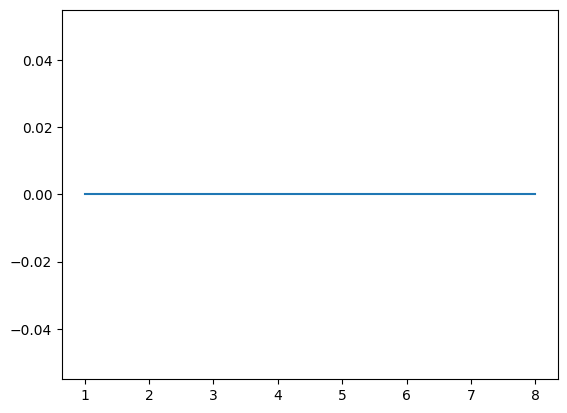

In [72]:
L_values = np.linspace(1, 8, 100)
energies = np.ones_like(L_values) * 1.5
calculator = FluxCalculator("./observed_flux.csv")
# energies = np.linspace(0.5, 8, 100)
# L_values = np.ones_like(energies) * 6.0
weights = calculator.get_weights(L_values, energies)
plt.plot(L_values, weights)
# plt.plot(energies, weights)
# plt.ylim(0, 1e-5)
# plt.xlim(6,7)

In [17]:
weights

array([7.15071761e-05, 6.64435670e-05, 6.13799579e-05, 5.63163489e-05,
       5.12527398e-05, 4.61891307e-05, 4.11255216e-05, 3.60619125e-05,
       3.12693611e-05, 2.95939719e-05, 2.79185827e-05, 2.62431936e-05,
       2.45678044e-05, 2.28924152e-05, 2.12170261e-05, 1.95416369e-05,
       1.78662477e-05, 1.61908586e-05, 1.45154694e-05, 1.28400802e-05,
       1.11646911e-05, 9.48930190e-06, 7.81391273e-06, 6.13852356e-06,
       4.81580753e-06, 4.60988972e-06, 4.40397192e-06, 4.19805412e-06,
       3.99213632e-06, 3.78621852e-06, 3.58030071e-06, 3.37438291e-06,
       3.16846511e-06, 2.96254731e-06, 2.75662951e-06, 2.55071170e-06,
       2.34479390e-06, 2.13887610e-06, 1.93295830e-06, 1.72704050e-06,
       1.52112269e-06, 1.31520489e-06, 1.10928709e-06, 9.03369288e-07,
       7.73462878e-07, 7.40298240e-07, 7.07133603e-07, 6.73968965e-07,
       6.40804327e-07, 6.07639689e-07, 5.74475051e-07, 5.41310413e-07,
       5.08145775e-07, 4.74981137e-07, 4.41816499e-07, 4.08651861e-07,
      